# AN2DL - Apple Elixir

This notebook contains code of a neural network used in a competition. The goal of the competition was to classify plants into two classes (healthy and unhealthy).
The model used in this notebook derived from a well known architecture, ConvNeXt, and uses an advanced augmentation technique called MixUp.

### Imports and Configs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install --upgrade tensorflow -q

In [ ]:
!pip install --upgrade keras-cv -q

**Imports**

In [ ]:
# Default Imports
import os
import logging
import functools
import warnings as wr
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_cv as kcv
from tensorflow import keras as tfk
from keras import layers as tkl
from keras import models as tkm
from keras.preprocessing.image import ImageDataGenerator, random_shear, random_shift
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

Using TensorFlow backend


**import of the dataset**

this dataset, as presented in the report, is derved from the original one by oversampling the elements in the less represented class

In [ ]:
!wget -q https://storage.googleapis.com/storage.barbiero.dev/public_data_clean_balanced.npz

**Randomnes and Configurations**

In [ ]:
# Random Configuration - All
RND = True
if not RND:
  SEED = 76998669
  os.environ['PYTHONHASHSEED'] = str(SEED)
  tf.compat.v1.set_random_seed(SEED)
  tf.random.set_seed(SEED)
  np.random.seed(SEED)
  rnd.seed(SEED)

# OS Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

# Warning Congiguration
wr.simplefilter(action='ignore', category=FutureWarning)
wr.simplefilter(action='ignore', category=Warning)

# TensorFlow Configuration
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

**TPU Setup**

In [ ]:
use_tpu = True  #set this parameter to FALSE if the tpu is not used

if 'COLAB_TPU_ADDR' in os.environ and use_tpu:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
  use_tpu = True
else : use_tpu = False

if use_tpu:
  tpu_address = TF_MASTER
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)

**Defining Functions**

In [ ]:
# Plotting Functions
# Function used for plotting the loss
def plot_losses(history, figsize, name_jpg):
  best_epoch = np.argmax(history['val_accuracy'])
  fig, axes = plt.subplots(2,1, figsize=figsize, dpi=200)

  axes[0].plot(history['loss'], label='Training Loss', color='#9859C5', alpha=.8)
  axes[0].plot(history['val_loss'], label='Validation Loss', color='#4D61E2', alpha=.8)
  axes[0].set_title('Loss')
  axes[0].legend()
  axes[0].grid(alpha=.3)

  axes[1].plot(history['accuracy'], label='Training Accuracy', color='#9859C5', alpha=.8)
  axes[1].plot(history['val_accuracy'], label='Validation Accuracy', color='#4D61E2', alpha=.8)
  axes[1].plot(best_epoch, history['val_accuracy'][best_epoch], marker='d', alpha=0.8, markersize=10, color='#4D61E2')
  axes[1].set_title('Accuracy')
  axes[1].legend()
  axes[1].grid(alpha=.3)

  plt.savefig(name_jpg)
  plt.show()

# Function used for compute the confusion Matrix
def plot_confusion_matrix(model, test, figsize, name_jpg):
  # Compute the confusion matrix
  y_pred = model.predict(test, verbose=0, steps=(len(X_val) // BATCH_SIZE))
  y_pred = np.argmax(y_pred, axis=-1)
  true_categories = tf.concat([np.argmax(y, axis=-1) for x, y in test], axis=0)
  cm = confusion_matrix(true_categories, y_pred)

  # Compute classification metrics
  accuracy = accuracy_score(true_categories, y_pred)
  precision = precision_score(true_categories, y_pred, average='macro')
  recall = recall_score(true_categories, y_pred, average='macro')
  f1 = f1_score(true_categories, y_pred, average='macro')

  # Display the computed metrics
  print('Accuracy:\t', accuracy.round(4))
  print('Precision:\t', precision.round(4))
  print('Recall:\t\t', recall.round(4))
  print('F1:\t\t', f1.round(4))

  # Plot the confusion matrix
  plt.figure(figsize=figsize, dpi=200)
  sns.heatmap(cm.T, annot=True, cmap='Blues')
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.savefig(name_jpg)
  plt.show()

# Function used for printig a set of images and their corresponding labels
def plot_images(images, labels, index=0, rows=1, cols=1, normalized=False):
  data_rescaling = tkl.Rescaling(scale=1./255)
  if normalized==False:
    IMGS_= data_rescaling(images)
  size = rows*cols
  diff = len(images)-(size+index)
  if diff <= 0:
    size = len(images)-index
    plt.figure(figsize=(cols,rows), dpi=200)
    for i in range(size):
      ax = plt.subplot(rows, cols, i + 1)
      plt.imshow(IMGS_[index + i])
      plt.title(labels[i], fontdict={"fontsize":5}, pad=2)
      plt.axis("off")


# Function used to make predictions
def test_prediction(model, test):
  y_pred = model.predict(test, verbose=0, steps=(len(X_val) // BATCH_SIZE))
  y_pred = np.argmax(y_pred, axis=-1)
  true_categories = tf.concat([np.argmax(y, axis=-1) for x, y in test], axis=0)
  test_accuracy = accuracy_score(true_categories, y_pred)
  print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
  print()

# Function used to plot 9 images belonging to the dataset
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

### Data Initizialization

**load the dataset**

In [ ]:
# Initializate
images, labels = np.load('public_data_clean_balanced.npz', allow_pickle=True).values()

print('Images shape: ', images.shape)
print('Labels shape: ', labels.shape)

# Map the categorical attributes into numbers
labels_map = {0: "healthy", 1: "unhealthy"}
labels_rev_map = {"healthy": 0, "unhealthy": 1}
labels = np.array([labels_rev_map[label] for label in labels])

Images shape:  (6120, 96, 96, 3)
Labels shape:  (6120,)


**Split the dataset**

In [ ]:
# Split the dataset into a combined training and validation set, and a separate test set
X_train, X_val, y_train, y_val = train_test_split(
    images,
    labels,
    test_size = 0.15,
    stratify = labels,
    random_state = 1234
)

# Conver the categorical attributes in one-hot encoding
y_train = tfk.utils.to_categorical(y_train, 2)
y_val = tfk.utils.to_categorical(y_val, 2)

# Get the Shape of IN OUT
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]

print(f'Input shape of the Network: {input_shape}')
print(f'Output shape of the Network: {output_shape}')
print()

Input shape of the Network: (96, 96, 3)
Output shape of the Network: 2



**Convert the dataset into a TensorFlow Dataset**

In [ ]:
# create a dataset object for each set
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

**Preprocess the data**

In [ ]:
# Assign the batch size, note that in case of tpu the batch must be bigger if we want to exploit its performance
if use_tpu:
  BATCH_SIZE = 128
else:
  BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = (96, 96)

# This function create a dictionary composed of images and labels
def to_dict(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    return {"images": image, "labels": label}


def prepare_trainset(dataset):
    return (
            dataset
            .cache()
            .shuffle(1000, reshuffle_each_iteration=True)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
            .repeat()
            .batch(BATCH_SIZE, drop_remainder=True)
        )

def prepare_valset(dataset):
    return (
            dataset
            .cache()
            .batch(BATCH_SIZE, drop_remainder=True)
        )

# Preprocess the train and validation set
train_dataset = prepare_trainset(train_dataset)
val_dataset = prepare_valset(val_dataset)

## *Augmentation*

**Define the MixUp function**

In [ ]:
mix_up = kcv.layers.MixUp()

def apply_mix_up(inputs):
    inputs = mix_up(inputs, training = True)
    return inputs

**Define other augmentation layers**

In [ ]:
post_aug = tfk.Sequential([
      tkl.RandomTranslation(height_factor=(-0.5,0.5),width_factor=(-0.5,0.5)),
      tkl.RandomZoom(height_factor=(-0.3,0.3),width_factor=(-0.3,0.3)),
      tkl.RandomFlip(),
      tkl.RandomRotation(factor=0.5)
    ]
  )

def apply_post_aug(inputs):
    inputs["images"] = post_aug(inputs["images"])
    return inputs

**Apply the augmentation functions to our dataset**

In [ ]:
def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

train_dataset = (
    train_dataset
    .map(apply_mix_up, num_parallel_calls=AUTOTUNE)
    .map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
)

train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)

#Define the Model

In [ ]:
from keras.applications.convnext import preprocess_input

def apple_elixir_model(input_shape, output_shape):

  # From Keras.application import ConvNeXt Base
  res = tfk.applications.ConvNeXtBase(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    classes=2,
    classifier_activation='softmax'
  )

  # Set convNeXt as not trainable
  res.trainable = False
  input_layer = tkl.Input(input_shape)   # input layer

  x = preprocess_input(input_layer) # preprocessing
  x = res(x)
  x = tkl.GlobalAveragePooling2D()(x) # GAP
  x = tkl.Dense(units=128,activation=tkl.LeakyReLU(alpha=0.3))(x)     # A dense layer
  x = tkl.Dropout(0.7)(x)

  output_layer = tkl.Dense(units=output_shape,activation='softmax')(x)  # output layer
  model = tfk.Model(input_layer, output_layer)

  # Compile the model
  model.compile(
      loss=tfk.losses.CategoricalCrossentropy(),
      optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001),
      metrics=['accuracy']
  )

  return model

if use_tpu:
  with strategy.scope():
    model = apple_elixir_model(input_shape,output_shape)
else:
  model = apple_elixir_model(input_shape,output_shape)

### Training

**CallBacks**

In [ ]:
# Early stopping
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=40,
    mode='max',
    restore_best_weights=True)

# Reduce LR on plateau
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    factor=0.85,
    mode='max',
    min_lr=1e-7
)

callbacks = [early_stopping, lr_scheduler]

**Fit the model**

In [ ]:
history = model.fit(
    train_dataset,
    epochs = 300,
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = len(X_val) // BATCH_SIZE,
    callbacks = callbacks
).history

Epoch 1/300
40/40 [==============================] - 28s 237ms/step - loss: 0.7545 - accuracy: 0.6559 - val_loss: 0.4330 - val_accuracy: 0.8013 - lr: 0.0010
Epoch 2/300
40/40 [==============================] - 6s 158ms/step - loss: 0.5592 - accuracy: 0.7527 - val_loss: 0.3954 - val_accuracy: 0.8449 - lr: 0.0010
Epoch 3/300
40/40 [==============================] - 4s 103ms/step - loss: 0.4900 - accuracy: 0.7840 - val_loss: 0.3769 - val_accuracy: 0.8348 - lr: 0.0010
Epoch 4/300
40/40 [==============================] - 4s 113ms/step - loss: 0.4824 - accuracy: 0.7893 - val_loss: 0.3718 - val_accuracy: 0.8516 - lr: 0.0010
Epoch 5/300
40/40 [==============================] - 3s 68ms/step - loss: 0.4695 - accuracy: 0.7971 - val_loss: 0.3664 - val_accuracy: 0.8460 - lr: 0.0010
Epoch 6/300
40/40 [==============================] - 4s 105ms/step - loss: 0.4613 - accuracy: 0.8084 - val_loss: 0.3457 - val_accuracy: 0.8705 - lr: 0.0010
Epoch 7/300
40/40 [==============================] - 3s 79ms/ste

### Saving and Plotting

In [ ]:
NAME_MODEL = "ConvNeXt_Only_MixUp"
NAME_PLOT = NAME_MODEL + "_plot"
NAME_CMATRIX = NAME_MODEL + "_cmatrix"

**Plots Loss**

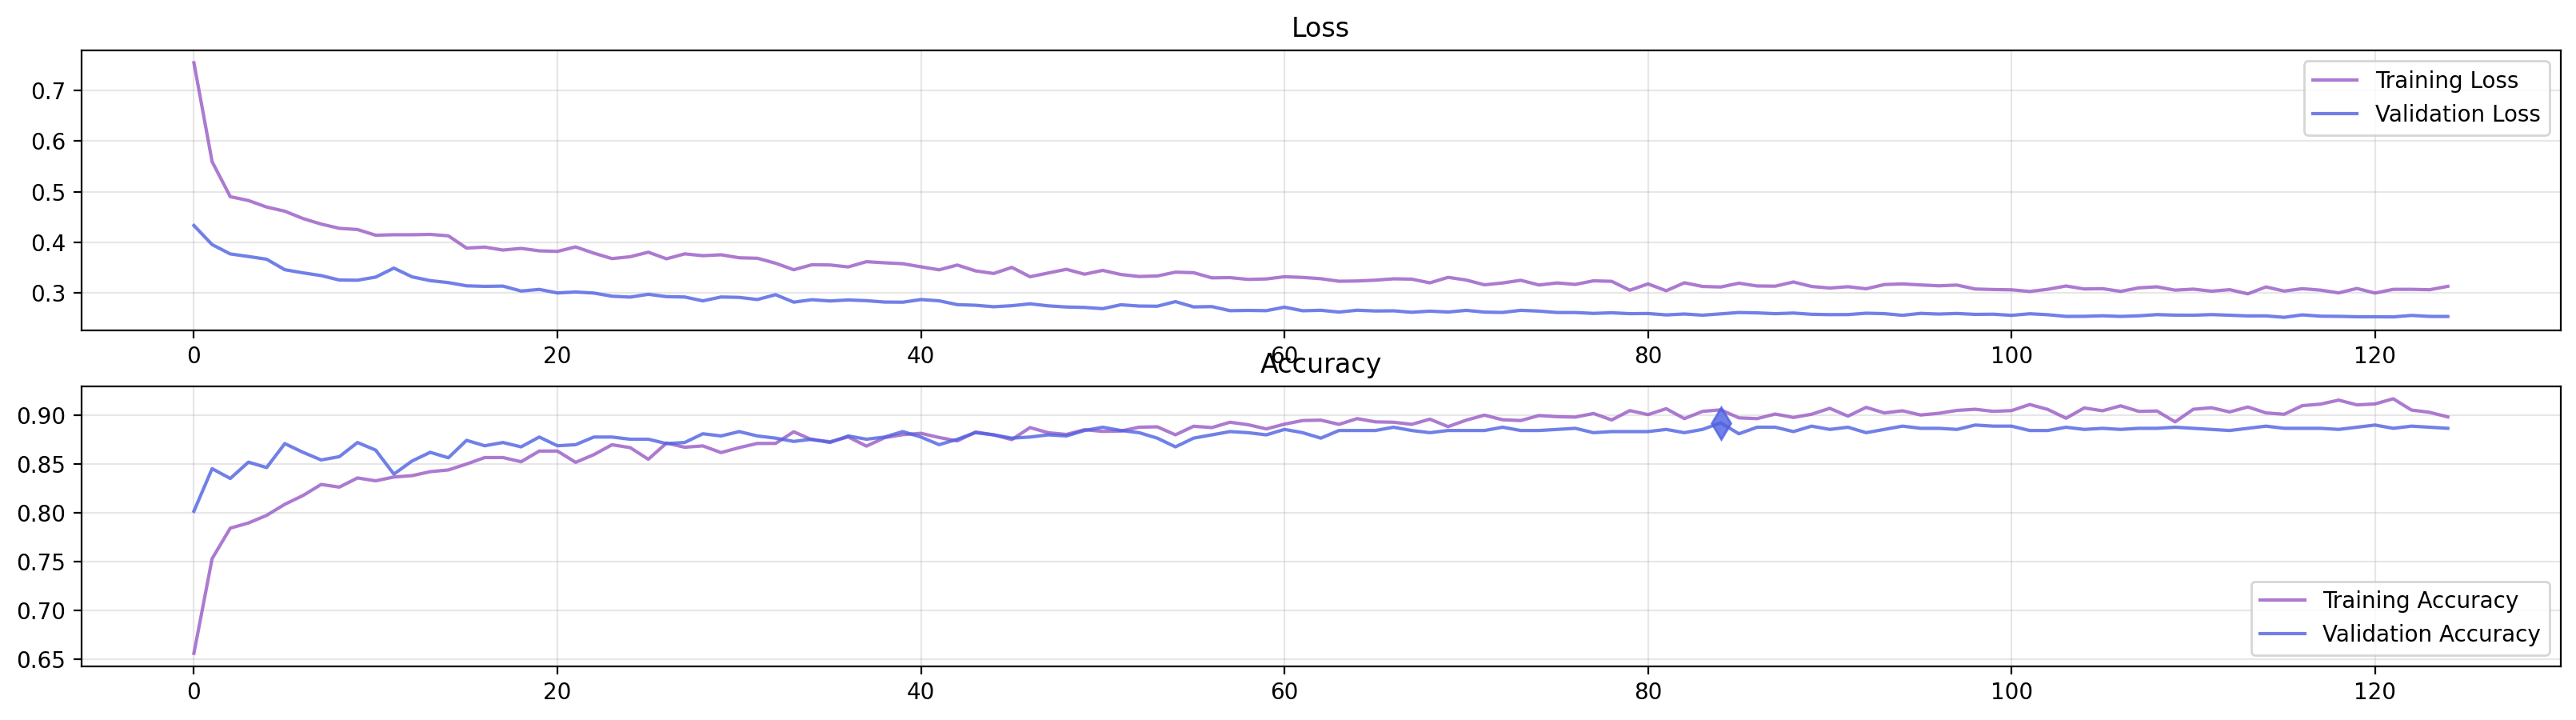

In [ ]:
plot_losses(history, (20,5), NAME_PLOT)

**Plot Confusion Matrix**

Exception ignored in: <function Executor.__del__ at 0x7db54606ac20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Accuracy:	 0.8917
Precision:	 0.8935
Recall:		 0.8919
F1:		 0.8916


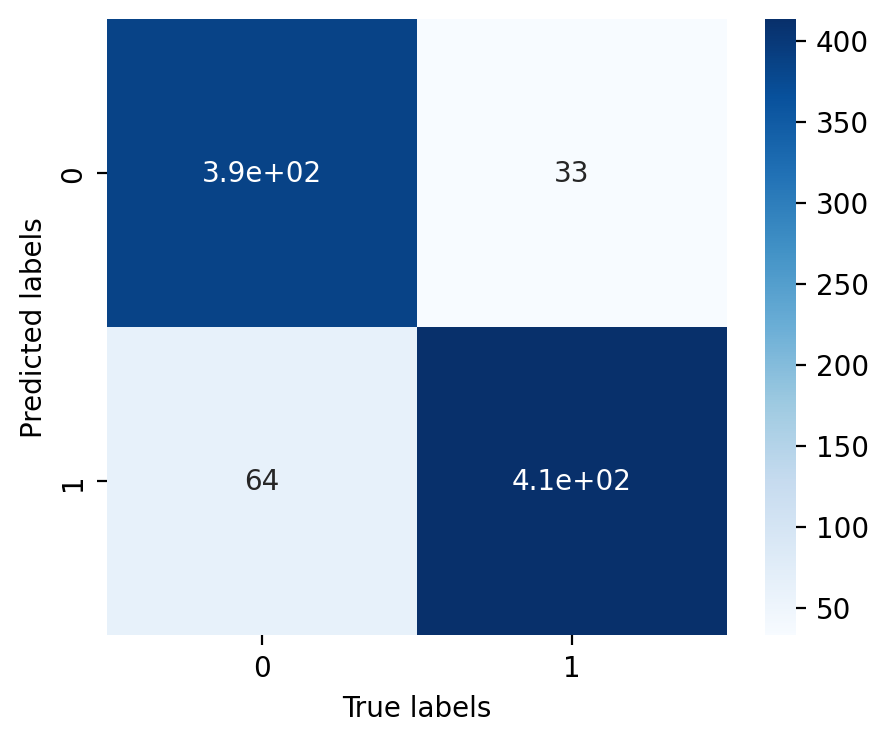

In [ ]:
plot_confusion_matrix(model, val_dataset, (5,4), NAME_CMATRIX)

**Save the Model**

In [ ]:
if use_tpu:
  # save model locally from tpu using Tensorflow's "SavedModel" format
  save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
  model.save(NAME_MODEL, options=save_locally)
else:
  model.save(NAME_MODEL)

**Delete the Model**

In [ ]:
del model, history

## Fine Tuning

**Load the Model**

In [ ]:
if use_tpu:
  with strategy.scope():
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    ft_model = tf.keras.models.load_model(NAME_MODEL, options=load_locally)
else:
  ft_model = tfk.models.load_model(NAME_MODEL)

**Train only the Last Layers**

In [ ]:
ft_model.get_layer('convnext_base').trainable = True

for i, layer in enumerate(ft_model.get_layer('convnext_base').layers[:200]):
  layer.trainable=False

ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001), metrics=['accuracy'])

**Train the Tuning Model**

In [ ]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=25,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    factor=0.80,
    mode='max',
    min_lr=1e-7
)

callbacks = [early_stopping, lr_scheduler]

history = ft_model.fit(
    train_dataset,
    epochs = 300,
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = len(X_val) // BATCH_SIZE,
    callbacks = callbacks
).history

Epoch 1/300
40/40 [==============================] - 99s 496ms/step - loss: 1.1120 - accuracy: 0.7707 - val_loss: 0.3597 - val_accuracy: 0.8460 - lr: 0.0010
Epoch 2/300
40/40 [==============================] - 6s 157ms/step - loss: 0.3226 - accuracy: 0.9006 - val_loss: 0.2106 - val_accuracy: 0.9107 - lr: 0.0010
Epoch 3/300
40/40 [==============================] - 4s 93ms/step - loss: 0.2543 - accuracy: 0.9324 - val_loss: 0.2899 - val_accuracy: 0.8850 - lr: 0.0010
Epoch 4/300
40/40 [==============================] - 7s 181ms/step - loss: 0.2407 - accuracy: 0.9449 - val_loss: 0.1853 - val_accuracy: 0.9308 - lr: 0.0010
Epoch 5/300
40/40 [==============================] - 6s 142ms/step - loss: 0.2078 - accuracy: 0.9611 - val_loss: 0.1801 - val_accuracy: 0.9308 - lr: 0.0010
Epoch 6/300
40/40 [==============================] - 7s 187ms/step - loss: 0.1959 - accuracy: 0.9631 - val_loss: 0.1862 - val_accuracy: 0.9442 - lr: 0.0010
Epoch 7/300
40/40 [==============================] - 4s 98ms/ste

### Saving and Plotting

In [ ]:
FT_NAME = NAME_MODEL+"_Tuning"
FT_PLOT = NAME_PLOT+"_Tuning"
FT_CMATRIX = NAME_CMATRIX+"_Tuning"

**Plot Loss**

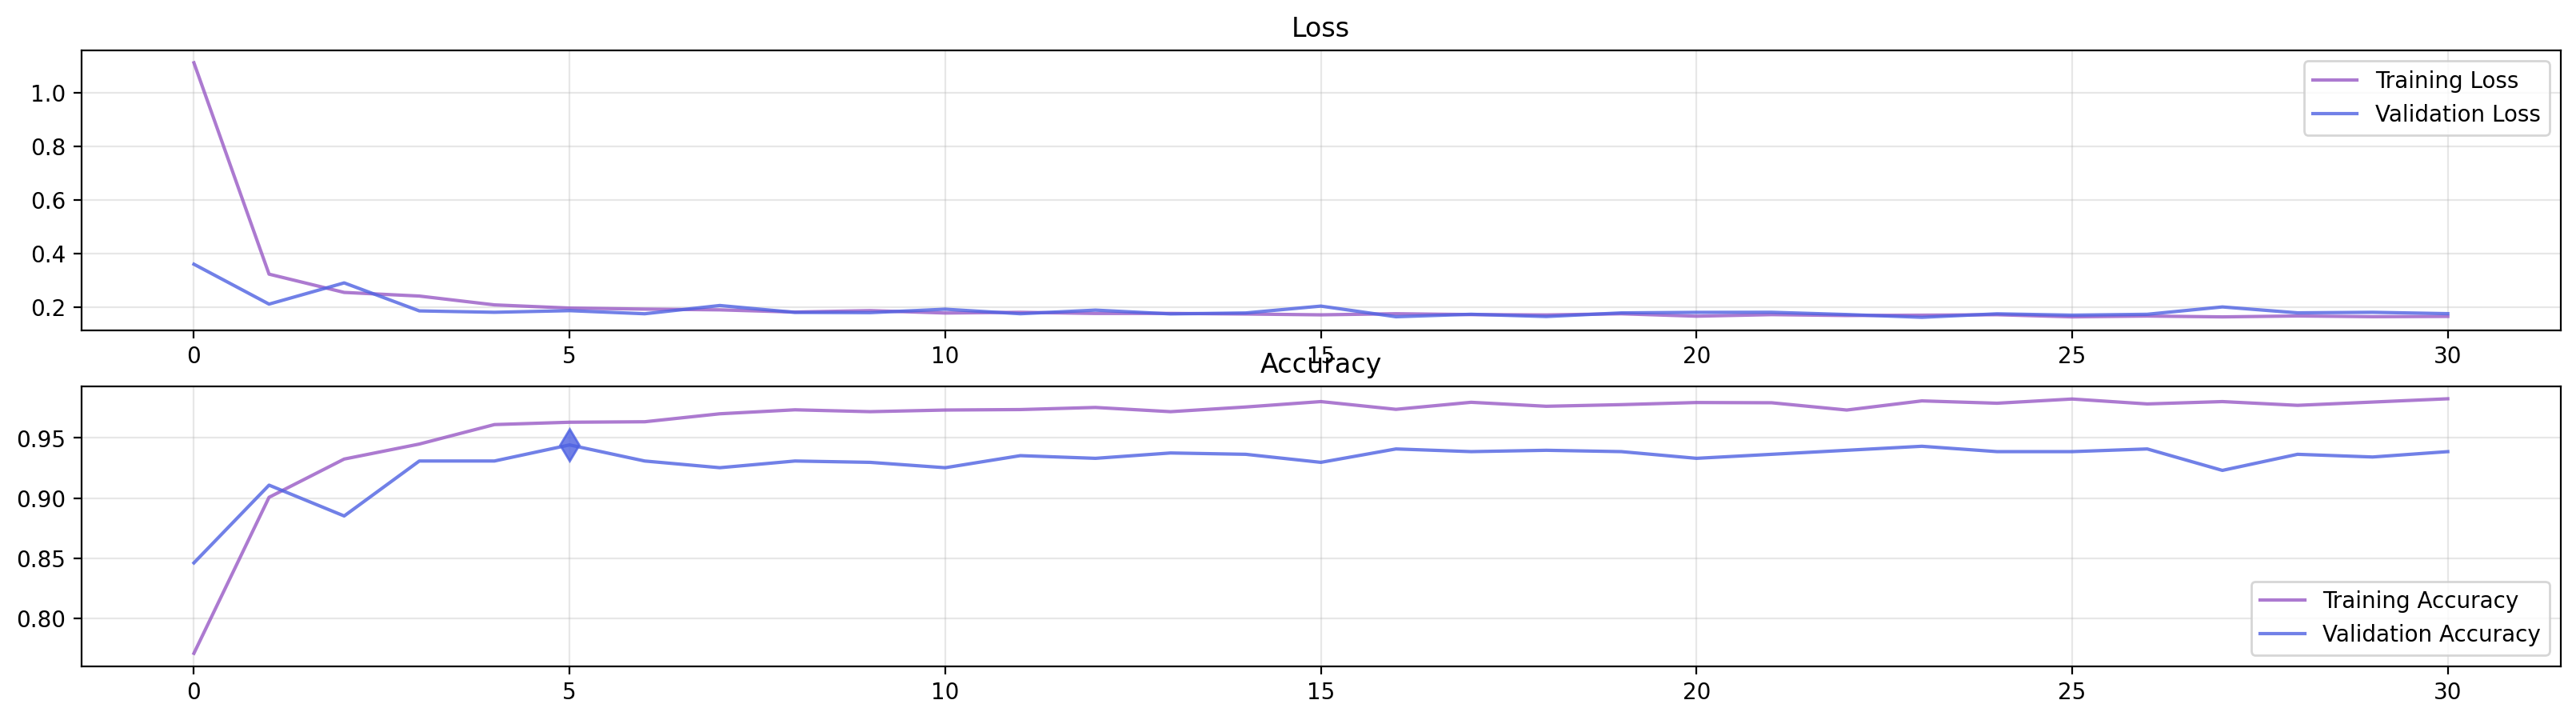

In [ ]:
plot_losses(history, (20,5), FT_PLOT)

**Plot Confusion Matrix**

Exception ignored in: <function Executor.__del__ at 0x7db54606ac20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Accuracy:	 0.9442
Precision:	 0.9446
Recall:		 0.9443
F1:		 0.9442


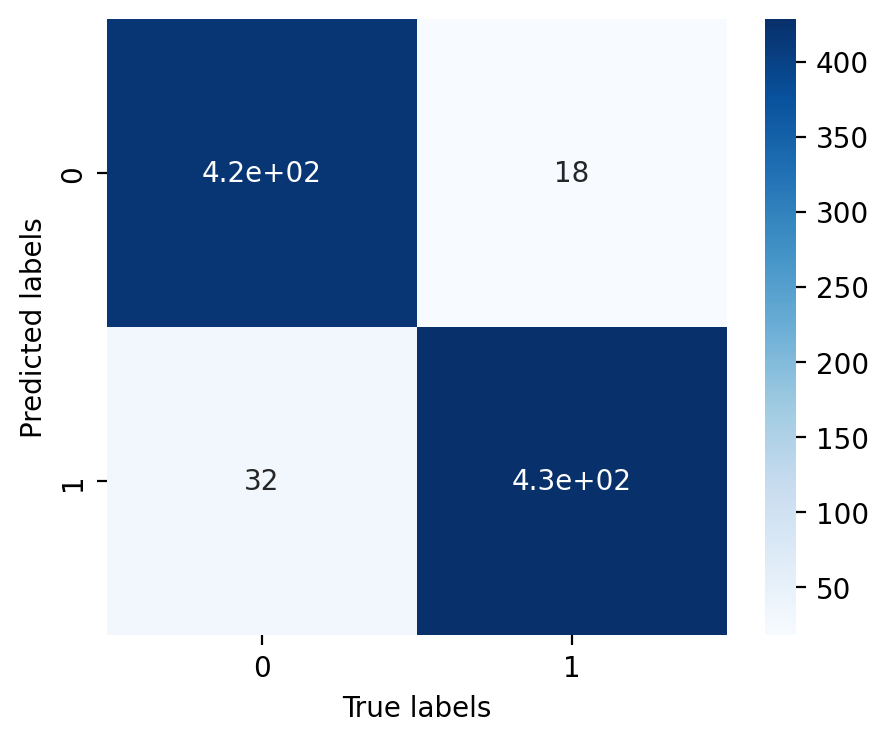

In [ ]:
plot_confusion_matrix(ft_model, val_dataset, (5,4), FT_CMATRIX)

**Save the Model**

In [ ]:
if use_tpu:
  # save model locally from tpu using Tensorflow's "SavedModel" format
  save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
  ft_model.save(FT_NAME, options=save_locally)
else:
  ft_model.save(FT_NAME)

# Zip the Model and the Plots

In [ ]:
!zip -r {FT_NAME}.zip {FT_NAME} {FT_PLOT}.png {FT_CMATRIX}.png
!cp {FT_NAME}.zip drive/MyDrive/

  adding: ConvNeXt_Only_MixUp_Tuning/ (stored 0%)
  adding: ConvNeXt_Only_MixUp_Tuning/saved_model.pb (deflated 92%)
  adding: ConvNeXt_Only_MixUp_Tuning/variables/ (stored 0%)
  adding: ConvNeXt_Only_MixUp_Tuning/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: ConvNeXt_Only_MixUp_Tuning/variables/variables.index (deflated 78%)
  adding: ConvNeXt_Only_MixUp_Tuning/assets/ (stored 0%)
  adding: ConvNeXt_Only_MixUp_Tuning/keras_metadata.pb (deflated 96%)
  adding: ConvNeXt_Only_MixUp_Tuning/fingerprint.pb (stored 0%)
  adding: ConvNeXt_Only_MixUp_plot_Tuning.png (deflated 16%)
  adding: ConvNeXt_Only_MixUp_cmatrix_Tuning.png (deflated 16%)


# Notes
We would like to thank the team of the 2023/2024 AN2DL course taught at Politecnico di Milano

More code available at this link: https://github.com/GioBar00/AN2DL_23-24_Apple_Elixir

Credits:
>*Andrea Alari*   https://github.com/andrea-alari

>*Giovanni Barbiero* https://github.com/GioBar00

>*Alexandro Sas*  https://github.com/AlexandroSas